# My first Autoencoder for Jet compression

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import awkward

In [2]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

## Getting the data
I will only use $p_T, \eta, \phi \text{ and } E$.

In [3]:
path_to_data = '../../data/'

folder15 = 'breynold/user.breynold.data15_13TeV.00284484.physics_Main.DAOD_NTUP_JTRIG_JETM1.r9264_p3083_p3601_j042_tree.root/'
file15 = 'user.breynold.18753218._000001.tree.root'
folder16 = 'breynold/user.breynold.data16_13TeV.00307656.physics_Main.DAOD_NTUP_JTRIG_JETM1.r9264_p3083_p3601_j042_tree.root/'
file16 = 'user.breynold.18797259._000001.tree.root'

# Load a ROOT file
filePath = path_to_data + folder16 + file16
ttree = uproot.open(filePath)['outTree']['nominal']

In [4]:
branchnames = ['nAntiKt4EMTopoJets_Calib2018',
               'AntiKt4EMTopoJets_Calib2018_E',
               'AntiKt4EMTopoJets_Calib2018_pt',
               'AntiKt4EMTopoJets_Calib2018_phi',
               'AntiKt4EMTopoJets_Calib2018_eta']

jaggedE = ttree.array(branchnames[1])
jaggedpT = ttree.array(branchnames[2])
jaggedphi = ttree.array(branchnames[3])
jaggedeta = ttree.array(branchnames[4])

In [5]:
jaggedE.counts

array([20,  9,  9, ...,  5, 18, 11])

In [6]:
jaggedE.content

array([212.2173  , 175.15614 ,  64.451935, ...,  24.369474,  13.941364,
        60.927433], dtype=float32)

In [7]:
def get_leading(jaggedX):
    return jaggedX[jaggedX.counts > 1, 0]

In [8]:
leading_E = get_leading(jaggedE)
leading_pT = get_leading(jaggedpT)
leading_phi = get_leading(jaggedphi)
leading_eta = get_leading(jaggedeta)

In [9]:
print(leading_E.shape, leading_eta.shape, leading_phi.shape, leading_pT.shape)

(1937902,) (1937902,) (1937902,) (1937902,)


In [10]:
df = pd.DataFrame(data = {'pT': leading_pT, 'eta': leading_eta, 'phi': leading_phi, 'E': leading_E})

In [11]:
df.head(10)

,pT,eta,phi,E
0,161.850494,-0.764774,2.287350,212.217300
1,164.702454,0.205651,-1.074816,169.021805
2,405.421387,-0.064094,-2.324020,407.661316
3,139.671234,-0.289339,-2.052494,145.860703
4,227.195618,2.158644,-1.864455,996.913025
5,180.480667,1.684722,-1.049987,503.476410
6,39.454185,-0.305395,0.755678,41.943340
7,202.920883,1.583752,-0.301926,515.302856
8,263.867432,-0.141594,-2.308791,267.712372
9,234.460327,-2.949176,2.114750,2244.307617


## Splitting into training and test sets

In [12]:
n_features = len(df.loc[0])

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
print(train.shape, test.shape)

(1550321, 4) (387581, 4)


In [14]:
# Normalize the features
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std  # Is this the right way to normalize? (only using train mean and std to normalize both train and test)

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Building models

I'm building three models of different sizes. The smallest one does not do any compression but acts as a control model. If that one isn't preforming well the larger models probably don't stand a chance either.

### Small model

In [31]:
model = nn.Sequential(
    nn.Linear(n_features, 4),
    nn.Tanh(),
    nn.Linear(4, n_features),
)

### Medium model

In [30]:
model_medium = nn.Sequential(
    nn.Linear(n_features, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 4),
    nn.Tanh(),
    nn.Linear(4, n_features),
)

### Large model

In [15]:
model_big = nn.Sequential(
    nn.Linear(n_features, 8),
    nn.Tanh(),
    nn.Linear(8, 6),
    nn.Tanh(),
    nn.Linear(6, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 4),
    nn.Tanh(),
    nn.Linear(4, 6),
    nn.Tanh(),
    nn.Linear(6, 8),
    nn.Tanh(),
    nn.Linear(8, n_features),
)

In [32]:
# Some helper functions
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)  # MSE-Loss
        if(epoch % 1 == 0):
            print('epoch: ' + str(epoch) + ',', 'validation loss: ' + str(val_loss))

In [33]:
bs = 64  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

## Training

In [40]:
epochs = 7
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0009844307802118835
epoch: 1, validation loss: 0.00035632431255999355
epoch: 2, validation loss: 0.0002777528047366488
epoch: 3, validation loss: 0.00023502431268229926
epoch: 4, validation loss: 0.00016193122171908675
epoch: 5, validation loss: 0.00013418651330728506
epoch: 6, validation loss: 0.00014093060209831513


In [41]:
epochs = 3
opt = optim.Adam(model.parameters(), lr=3e-4)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 9.535449994789525e-05
epoch: 1, validation loss: 0.00010508833575059822
epoch: 2, validation loss: 8.913892355854045e-05


In [52]:
epochs = 2
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 8.290619633248439e-05
epoch: 1, validation loss: 7.434683948677615e-05


### Look at reconstructed input vs input

In [47]:
model.eval()
for ii in np.arange(100, 110):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6947, -0.6949,  1.6949,  0.2685], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1764, -0.1663, -0.0322, -0.6019], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3694,  0.6493,  1.3031, -0.5489], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3686, -0.0116,  1.0882, -0.7304], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7826, -0.4028,  1.1527, -0.7632], grad_fn=<AddBackward0>)
 
Inp: tensor([0.4060, 1.5628, 1.4620, 1.8385])
Out: tensor([0.4039, 1.5715, 1.4670, 1.8401], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.0816, -0.7146, -1.2172, -0.3813])
Out: tensor([-0.0820, -0.7157, -1.2190, -0.3817], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.4208,  0.0398, -1.2887, -0.5597])
Out: tensor([ 0.4260,  0.0373, -1.2920, -0.5622], grad_fn=<AddBackward0>)
 


In [48]:
idxs = (4000, 4010)  # Choose events to compare
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred = model(data).detach().numpy()

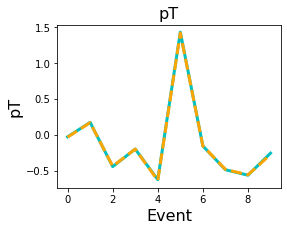

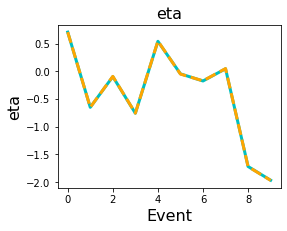

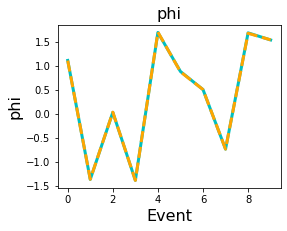

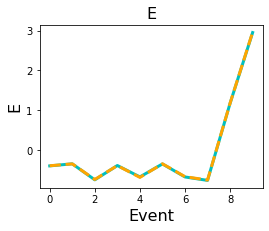

In [49]:
# Plot input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)

## Train medium model

In [34]:
epochs = 7
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=1e-3)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0071031145864480375
epoch: 1, validation loss: 0.003993334070137736
epoch: 2, validation loss: 0.0033867725383697053
epoch: 3, validation loss: 0.0027295692297380748
epoch: 4, validation loss: 0.0024779109284955147
epoch: 5, validation loss: 0.0023105130185880865
epoch: 6, validation loss: 0.002153293904756846


In [53]:
epochs = 4
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=3e-4)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0016941647404318198


In [55]:
epochs = 3
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=1e-4)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0016555217954483301


In [56]:
model_medium.eval()
# Print a few tensors
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_medium(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.7135, -0.7071,  1.6687,  0.2947], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1755, -0.1707, -0.0298, -0.6018], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3683,  0.6787,  1.3055, -0.5602], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3568, -0.0094,  1.0927, -0.7506], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7631, -0.4226,  1.1515, -0.7792], grad_fn=<AddBackward0>)
 


In [57]:
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred_medium = model_medium(data).detach().numpy()

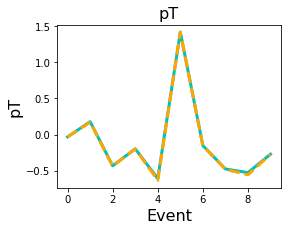

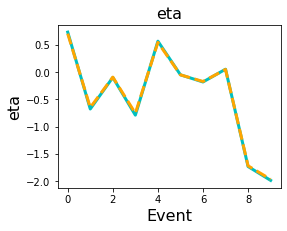

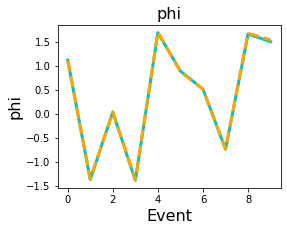

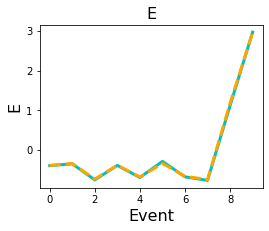

In [58]:
# Plot input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred_medium[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)

## Train big model

In [24]:
epochs = 5
loss_func = nn.MSELoss()
opt = optim.Adam(model_big.parameters(), lr=1e-3)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0017792597405557557
epoch: 1, validation loss: 0.000810179051559203
epoch: 2, validation loss: 0.0005137063176305504
epoch: 3, validation loss: 0.0004947753889614501
epoch: 4, validation loss: 0.0005493387988039543
epoch: 5, validation loss: 0.0002923736576316176
epoch: 6, validation loss: 0.0009838177678324384


In [25]:
epochs = 3
opt = optim.Adam(model_big.parameters(), lr=3e-4)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.00015559877844366005
epoch: 1, validation loss: 0.00014563928884266534
epoch: 2, validation loss: 0.00018043840776302278
epoch: 3, validation loss: 0.00013213020094798473
epoch: 4, validation loss: 0.00013957830705647303


In [59]:
epochs = 3
opt = optim.Adam(model_big.parameters(), lr=1e-4)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.00011801705487568865
epoch: 1, validation loss: 0.00010968197991833399
epoch: 2, validation loss: 0.0001064412479691467


In [70]:
epochs = 2
opt = optim.Adam(model_big.parameters(), lr=3e-5)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.00010100461992341448
epoch: 1, validation loss: 9.994042056550185e-05
epoch: 2, validation loss: 0.00010165762972498648


In [71]:
epochs = 2
opt = optim.Adam(model_big.parameters(), lr=1e-5)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 9.768235615447091e-05
epoch: 1, validation loss: 9.790363399057029e-05


In [72]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/model_big.pt'  # Last save had valid loss = 9.8e-5
#torch.save(model_big.state_dict(), save_path)
# model_big = nn.Sequential()
# model_big.load_state_dict(torch.load(save_path))
# model.eval()

In [73]:
model_big.eval()
# Print a few tensors
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6929, -0.7071,  1.6811,  0.2879], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1771, -0.1679, -0.0348, -0.5987], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3788,  0.6442,  1.3004, -0.5356], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3723, -0.0121,  1.0918, -0.7290], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7824, -0.3992,  1.1664, -0.7665], grad_fn=<AddBackward0>)
 


In [74]:
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred_big = model_big(data).detach().numpy()

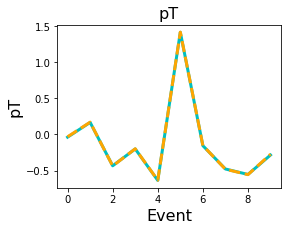

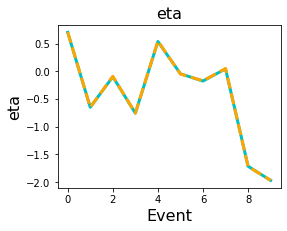

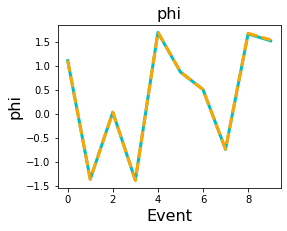

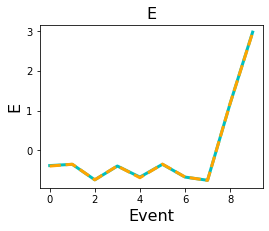

In [75]:
# Plot input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred_big[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)